# Near earth objects
---
Generates a graph which shows the amount of different NEO diameter sizes

Data Source:
https://cneos.jpl.nasa.gov/ca/

### Constants

In [198]:
from matplotlib import pyplot as plt
import pandas as pd

### Filter Constants

In [199]:
# distance in lunar distances
filter_distance = 20.0

# max diameter
filter_max_mean_diameter = 1000

### Data Import, Cleaning

In [200]:
df = pd.read_csv("cneos_closeapproach_data.csv", sep=",")
df = df.drop(columns=['CA Distance Minimum (LD | au)', 'V relative (km/s)', 'V infinity (km/s)', 'H (mag)', 'Unnamed: 8'])

df["LD"] = df["CA Distance Nominal (LD | au)"].str.split(' ', expand = True)[0]
df["LD"] = pd.to_numeric(df["LD"], errors='coerce')

# ignore +/-, not accurate timing necessary for this graph
df["approach_time"] = pd.to_datetime(df["Close-Approach (CA) Date"].str.split('±', expand = True)[0])
df.head(3)

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),Diameter,LD,approach_time
0,99942 Apophis (2004 MN4),2029-Apr-13 21:46 ± < 00:01,0.10 | 0.00025,0.34±0.04 km,0.10,2029-04-13 21:46:00
1,(2010 RF12),2095-Sep-06 00:06 ± 00:44,0.10 | 0.00026,5.6 m - 12 m,0.10,2095-09-06 00:06:00
2,(2007 UW1),2129-Oct-19 03:09 ± 01:30,0.22 | 0.00056,77 m - 170 m,0.22,2129-10-19 03:09:00


### Calculation

In [201]:
df["distance_km"] = df["LD"]*394_399

# read km or m
df["size_unit"] = df["Diameter"].str[-2:]

# divide all diameters with ±
df["d1"] = df["Diameter"].str.split('±', expand = True)[0]
df["d1"] = pd.to_numeric(df["d1"], errors='coerce')

# set size factor = 1000, except when " m" = 1
df["size_factor"] = 1_000
df.loc[df["size_unit"] == " m", "size_factor"] = 1

# calculate mean diameter
df["d_von"] = df["Diameter"].str.split(' ', expand = True)[0]
df["d_von"] = pd.to_numeric(df["d_von"], errors='coerce')

df["d_bis"] = df["Diameter"].str.split('- ', expand = True)[1]
df["d_bis"] = df["d_bis"].str.split(' m', expand = True)[0]
df["d_bis"] = pd.to_numeric(df["d_bis"], errors='coerce')

df["mittel1"] = df["d1"] * df["size_factor"]
df["mittel1"] = df["mittel1"].fillna(1)

df["mittel2"] = (df["d_von"]+df["d_bis"]) *(1/2) * df["size_factor"]
df["mittel2"] = df["mittel2"].fillna(1)

df["diameter_mean"] = df["mittel1"] * df["mittel2"]

df["diameter_rounded"] = df["diameter_mean"].round(0)

# perform filtering
df = df.loc[df["LD"] < filter_distance]
df = df.loc[df["diameter_rounded"] < filter_max_mean_diameter]

df = df.drop(columns=['d1', 
                      'd_von', 
                      'd_bis', 
                      'mittel1', 
                      'mittel2', 
                      'size_factor', 
                      'CA Distance Nominal (LD | au)', 
                      'size_unit'])

df.head(3)

diameter_means = df.groupby("diameter_rounded")

### Visualize

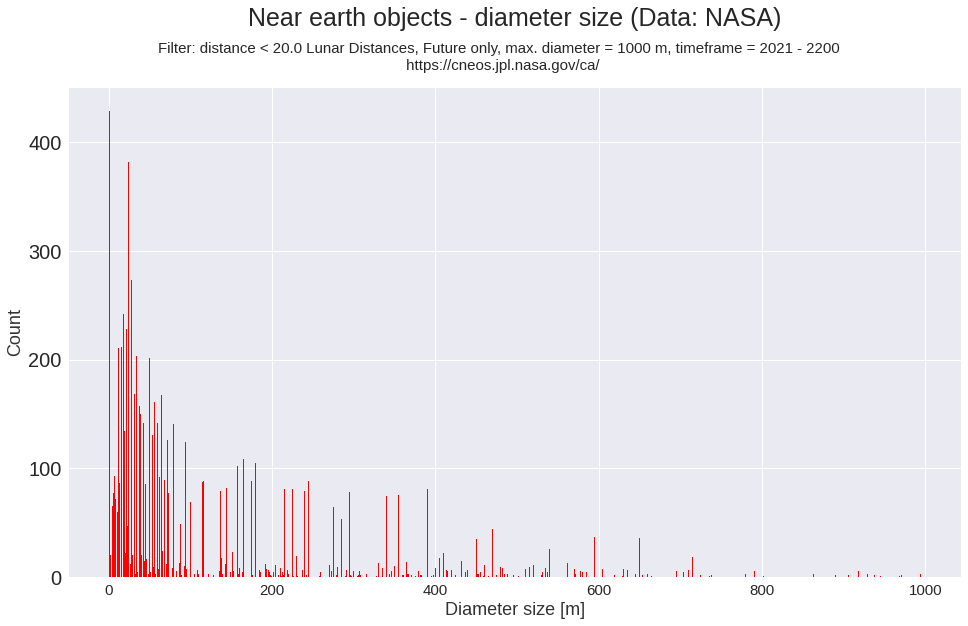

In [202]:
plt.style.use('seaborn')

plt.figure(figsize=(16, 9))

plt.bar(diameter_means.size().index, diameter_means.size().values, color='red')

plt.xlabel("Diameter size [m]", color="black", alpha=0.8, fontsize=18)
plt.ylabel("Count", color="black", alpha=0.8, fontsize=18)

plt.tick_params(labelsize=20, axis='y')
plt.tick_params(labelsize=15, axis='x')

plt.title(f' Near earth objects - diameter size (Data: NASA) \n\n', fontsize=25)
plt.suptitle(f'Filter: distance < {filter_distance} Lunar Distances, Future only, max. diameter = {filter_max_mean_diameter} m, timeframe = {df["approach_time"].min().year} - {df["approach_time"].max().year} \n https://cneos.jpl.nasa.gov/ca/', fontsize=15, y=0.95)

plt.savefig(f'NEO2_{filter_distance} Lunar Diameter sizes.png', dpi=300, bbox_inches='tight')